In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import surprise
import numpy as np
import pandas as pd
import pickle

from surprise import BaselineOnly
from surprise import Dataset
from surprise import Reader
from surprise import SVD
from surprise import SVDpp
from surprise import KNNWithMeans
from surprise import SlopeOne
from surprise.model_selection import cross_validate
from tqdm import tqdm_notebook, tqdm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from surprise import accuracy
from surprise.model_selection import KFold
from multiprocessing import Pool
tqdm = tqdm_notebook

In [2]:
# this is hack, but who cares, use script as default folder
# otherwise the pickle doens't work
import sys
sys.path.insert(0, 'script')

import dataset as d
import models as m
import submission as s

In [4]:
# - try implicit library

In [30]:
# I have to convert the 
def deal_line(line):
    pos, rating = line.split(',')
    row, col = pos.split("_")
    row = row.replace("r", "")
    col = col.replace("c", "")
    return int(row), int(col), float(rating)

def read_txt(path):
    """read text file from path."""
    with open(path, "r") as f:
        return f.read().splitlines()
    
file_path = 'data/data_train.csv'
lines = read_txt(file_path)[1:]
data = [deal_line(line) for line in lines]

#shuffle(data)
#data = data[:100_000]

with open('data/kiru.csv', 'w') as f:
    for item in data:
        f.write("{},{},{}\n".format(item[0], item[1], item[2]))

# path to dataset file
file_path = 'data/kiru.csv'
reader = Reader(line_format='user item rating', sep=',')
data = Dataset.load_from_file(file_path, reader=reader)

In [ ]:
def call_algo(i):
    trainset, testset = i
    # train and test algorithm.
    algo = SlopeOne()
    algo.fit(trainset)
    predictions = algo.test(testset)
    # Compute and print Root Mean Squared Error
    rmse = accuracy.rmse(predictions, verbose=True)
    return (algo, rmse)
        
def predict():
    with Pool(10) as p:
        # define a cross-validation iterator
        kf = KFold(n_splits=3)
        return p.map(call_algo, kf.split(data))

In [ ]:
%%time
predictions = predict()
best_model_slope_one = min(predictions, key=lambda b: b[1])

In [ ]:
def create_predictions(predictor):
    lines = read_txt('data/sample_submission.csv')[1:]
    data = [deal_line(line) for line in lines]

    predictions = []
    for i, each in tqdm(enumerate(data)):
        pred1 = predictor.predict(str(each[0]), str(each[1])).est
        predictions.append((each[2], int(round(pred1))))

    return predictions

In [ ]:
predictions = create_predictions(best_model_slope_one[0])

In [ ]:
from random import shuffle
predictor = best_model_slope_one[0]

def do_predict(predictor):
    lines = read_txt('data/data_train.csv')[1:]
    data = [deal_line(line) for line in lines]
    shuffle(data)

    predictions = []
    for i, each in tqdm(enumerate(data), total=len(data)):
        pred = predictor.predict(str(each[0]), str(each[1])).est
        real = each[2]
        # [predictions, real]
        predictions.append([int(round(pred)), int(real)])
        #if i == 10: break

    predictions = np.array(predictions)
    return predictions

In [ ]:
predictions = do_predict(predictor)

In [ ]:
# correct category 3
#    predictions
#    rating = 5

def plot(predictions):
    data = np.zeros((5, 5), dtype=int)
    for rating in range(1, 6):
        correct = len(predictions[predictions[:, 1] == rating])

        #np.where(predictions[:, 1] == predictions[:, 0])
        #print(correct)
        p = []
        for i in range(1, 6):
            x = len(predictions[(predictions[:, 1] == rating) & (predictions[:, 0] == i)])
            data[(rating - 1, i - 1)] = x

    data = np.nan_to_num(data/data.sum(axis=1, keepdims=True))

    x = pd.DataFrame(data=data, index=range(1, 6), columns=range(1, 6))
    x.plot.bar(stacked=True)
    
plot(predictions)

In [ ]:
def call_algo_svd(i):
    trainset, testset = i
    print("Run one split")
    # train and test algorithm.
    algo = SVDpp()
    algo.fit(trainset)
    predictions = algo.test(testset)
    # Compute and print Root Mean Squared Error
    rmse = accuracy.rmse(predictions, verbose=True)
    return (algo, rmse)
        
def predict_svd():
    with Pool(10) as p:
        # define a cross-validation iterator
        kf = KFold(n_splits=10)
        return p.map(call_algo_svd, kf.split(data))

In [ ]:
%%time
predictions_svd = predict_svd()
best_model_svd = min(predictions_svd, key=lambda b: b[1])

In [ ]:
x = do_predict(best_model_svd[0])

Lets train a linear regression to find the best coefficient

In [ ]:
#plot(x)
#plot(predictions)
#plot(x)
error = np.sqrt(mean_squared_error(x[:, 0], x[:, 1]))
error

In [ ]:
def combine(first, second):
    kf = KFold(n_splits=3)
    weights = []
    for trainset, testset in tqdm(kf.split(data), desc="split"):
        print("Do one split")
        input_for_linear = []
        for each in tqdm(trainset.all_ratings(), desc="Process rating of split"):
            pred1 = first.predict(str(each[0]), str(each[1])).est
            pred2 = second.predict(str(each[0]), str(each[1])).est
            output = [pred1, pred2]
            input_for_linear.append(output)
        
        y = list(map(lambda x: x[2], trainset.all_ratings()))
        eg = LinearRegression().fit(input_for_linear, y)
        
        predictions = []
        c = eg.coef_
        for i, b in enumerate(input_for_linear):
           # p = b[0] * c[0] + b[1] + c[1]
            p = b[0] * 0.5 + b[1] + 0.5
            predictions.append(p)
            
        error = np.sqrt(mean_squared_error(y, predictions))
        weights.append((error, c))
        
    return min(weights, key=lambda b: b[0])

In [ ]:
best_weights = combine(best_model_slope_one[0], best_model_svd[0])

In [ ]:
print(best_weights)

In [ ]:
print(best_weights)

In [ ]:
def create_submission_file(first, second, w1, w2):
    lines = read_txt('data/sample_submission.csv')[1:]
    data = [deal_line(line) for line in lines]

    predictions = []
    for each in tqdm(data):
        pred1 = first.predict(str(each[0]), str(each[1])).est
        pred2 = second.predict(str(each[0]), str(each[1])).est
        predictions.append((each[0], each[1], pred1 * w1 + pred2 * w2 ))

    with open('data/our_pred.csv', 'w') as f:
        f.write("Id,Prediction\n")
        for item in tqdm(predictions):
            f.write("r{}_c{},{}\n".format(item[0], item[1], int(round(item[2]))))

In [ ]:
create_submission_file(avd, algo)

In [ ]:
accuracy.rmse(algo, verbose=True)

### Blending

1. Get two separate models and try to combine them and see if the perform good

In [17]:
with Pool(12) as p:
#    models = ["SurpriseSlopeOneModel", "SurpriseSlopeOneModel"]
    models = ["SurpriseKNNBasic"]
    result = m.cross_validates_one_by_one(p, models, path="data/data_surprise.csv", splits=3)

Running with models '['SurpriseKNNBasic']' and split 3
Split data
running CV


CV:   0%|          | 0/3 [00:00<?, ?it/s]

Fit models


KNNBasic:   0%|          | 0/1 [00:00<?, ?it/s]

Computing the msd similarity matrix...
Fit models


KNNBasic:   0%|          | 0/1 [00:00<?, ?it/s]

Computing the msd similarity matrix...
Fit models


KNNBasic:   0%|          | 0/1 [00:00<?, ?it/s]

Computing the msd similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.


KNNBasic: 100%|██████████| 1/1 [16:27<00:00, 987.10s/it]


Do blending


KNNBasic: 100%|██████████| 1/1 [16:26<00:00, 986.46s/it]


Do blending


KNNBasic: 100%|██████████| 1/1 [16:23<00:00, 983.64s/it]


Do blending


100%|██████████| 392317/392317 [05:35<00:00, 1170.60it/s]


Optimization terminated successfully.
         Current function value: 1.030272
         Iterations: 2
         Function evaluations: 12
         Gradient evaluations: 4
Best blended rmse:  1.0302717840871183
Optimization terminated successfully.
         Current function value: 1.031227
         Iterations: 2
         Function evaluations: 12
         Gradient evaluations: 4
Best blended rmse:  1.0312273140879833
Optimization terminated successfully.
         Current function value: 1.032666
         Iterations: 2
         Function evaluations: 12
         Gradient evaluations: 4
Best blended rmse:  1.032665689267196


CV: 100%|██████████| 3/3 [22:34<00:00, 451.60s/it] 


OSError: [Errno 22] Invalid argument

In [7]:
from scipy.optimize import minimize

In [16]:
x = result[0][0][0]
x.algo

In [90]:
data = d.to_surprise_read('data/data_surprise.csv')
data.split(10)

In [95]:
first = list(data.raw_folds())[0]
data_to_predict = first[1][:1000]

In [122]:
# Get all predictions
def get_predictions(models, data_to_predict): 
    result = []
    for each_data in tqdm(data_to_predict):
        predictions = []
        for each_model in models:
            p = each_model.algo.predict(each_data[0], each_data[1]).est
            predictions.append(p)
        result.append(predictions)
    return result

models = [result[0][0], result[1][0]]
model_predictions = get_predictions(models, data_to_predict)

In [114]:
real = list(map(lambda x: x[2], data_to_predict))

In [123]:
w0 = [1 / len(models)] * len(models)

In [171]:
def create_predictions():
    preds = []
    for i, pred in enumerate(model_predictions):
        mix_prediction = 0
        for i, w in enumerate(weights):
            mix_prediction += weights[i] * pred[i]
        preds.append(mix_prediction)
    preds = np.array(preds)
    preds = preds.clip(1, 5)
    
def calcualte_mean_square_error(weights, model_predictions):
    preds = create_predictions(weights, model_predictions)

    mse = mean_squared_error(preds, real)
    return np.sqrt(mse)

In [173]:
result = minimize(fun=calcualte_mean_square_error, x0=w0,
                  args = (model_predictions),
                  options={'maxiter': 1000, 'disp': True})

Optimization terminated successfully.
         Current function value: 0.988783
         Iterations: 12
         Function evaluations: 60
         Gradient evaluations: 15


In [183]:
result.fun

0.9887825093824633

In [152]:
def predict_one(weights, models, one_data):
    print("ja")

In [163]:
all_predictions = get_predictions(models, data.raw_ratings)

In [170]:
predictions = all_predictions @ result.x

In [ ]:
kf = KFold(n_splits=10)
for train, test in kf.split(data):
    print(test.)
    adsfas

### Predict based on splitting

In [82]:
lower_result_file = "run_9_split_full_without_blending/lower.result"
lower_result = pickle.load(open(lower_result_file, 'rb'))
lower_algo = min(list(map(lambda x: x[0], lower_result)), key=lambda x: x[0].rmse)[0]

In [83]:
upper_result_file = "run_9_split_full_without_blending/upper.result"
upper_result = pickle.load(open(upper_result_file, 'rb'))
upper_algo = min(list(map(lambda x: x[0], upper_result)), key=lambda x: x[0].rmse)[0]

In [295]:
def split_user_movie(pandas_data_frame):
    user_movie = pandas_data_frame.Id.str.extract(r'r(?P<user>\d+)_c(?P<movie>\d+)')
    pandas_data_frame['user'] = user_movie.user
    pandas_data_frame['movie'] = user_movie.movie
    return pandas_data_frame[['user', 'movie', 'Prediction']]

In [296]:
data = pd.read_csv('data/data_train.csv')
data = split_user_movie(data)
movie = data.groupby('user')['movie'].count().to_frame()
median = movie.median().values[0]
df_few_ratings = movie[movie['movie'] < median]
df_lower = data.merge(df_few_ratings.reset_index(), left_on='user', right_on='user', how='inner')

In [313]:
small = data[data.user.astype(int) <= 10]
small = small[small.movie.astype(int) <= 10]
small.to_csv('data/data_surprise_small.csv', index=False, header=False)

In [314]:
print(len(df_lower.user.unique()))

4956


In [87]:
df_submission = pd.read_csv('data/sample_submission.csv')
df_submission = split_user_movie(df_submission)

In [88]:
print(len(df_submission.user.unique()))

10000


In [89]:
df_lower_user = set(df_lower.user.values)
predictions = []
for each in tqdm(df_submission.iterrows(), total=len(df_submission)):
    user = each[1].user
    movie = each[1].movie
    if user in df_lower_user:
        prediction = lower_algo.algo.predict(str(user), str(movie)).est
    else:
        prediction = upper_algo.algo.predict(str(user), str(movie)).est
    predictions.append((user, movie, prediction))

In [92]:
np.mean([lower_algo.rmse, upper_algo.rmse])

0.9848610866985605

In [93]:
x = s.write_predictions_to_file(predictions, "run_9_split_full_without_blending/submission.csv")

100%|██████████| 1176952/1176952 [00:02<00:00, 435800.81it/s]


In [99]:
first = list(map(lambda x: x[2], new_predictions))
second = list(map(lambda x: x[2], predictions))

array([3.4244113 , 2.99486374, 3.72778865, ..., 3.40182707, 3.39634278,
       3.89578367])

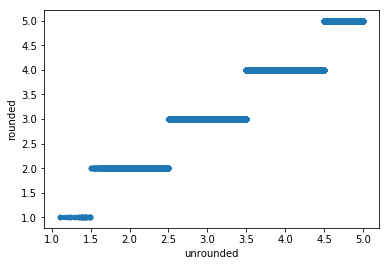

In [140]:
pd.DataFrame(data={'unrounded': first, 'rounded': np.round(first)}).plot.scatter(x='unrounded', y='rounded')

### Predict with weights

In [6]:
file = "run_10_new_blending_default/all_blending.result"

In [7]:
file_loaded = pickle.load(open(file, 'rb'))

In [8]:
x = list(map(lambda x: x[1].fun, file_loaded))

AttributeError: 'NoneType' object has no attribute 'fun'

[([<models.SurpriseBasedModel at 0x11969e6d8>,
  None),
 ([<models.SurpriseBasedModel at 0x1a31d031d0>,
  None),
 ([<models.SurpriseBasedModel at 0x1a48844080>,
  None),
 ([<models.SurpriseBasedModel at 0x1a4fb5bf98>,
  None),
 ([<models.SurpriseBasedModel at 0x1a604cee80>,
  None),
 ([<models.SurpriseBasedModel at 0x1aa897ad30>,
  None),
 ([<models.SurpriseBasedModel at 0x1ab9287be0>,
  None),
 ([<models.SurpriseBasedModel at 0x1b291a6a90>,
  None),
 ([<models.SurpriseBasedModel at 0x1b39a75978>,
  None),
 ([<models.SurpriseBasedModel at 0x1bb1a84860>,
  None),
 ([<models.SurpriseBasedModel at 0x1bc2387748>,
  None),
 ([<models.SurpriseBasedModel at 0x1bd2dcc630>,
  None)]

In [39]:
best = file_loaded[0]
models = best[0]
weights = best[1].x

In [66]:
list(map(lambda x: x.name, models))

['BaselineOnly', 'KNNBasic', 'SVD']

In [40]:
predictions = []
for each in tqdm(df_submission.iterrows(), total=len(df_submission)):
    user = each[1].user
    movie = each[1].movie
    
    mix_prediction = 0
    for i, w in enumerate(models):
        pred = w.algo.predict(user, movie).est
        mix_prediction += weights[i] * pred
    predictions.append(mix_prediction)

In [55]:
clipped_predictions = np.clip(predictions, 1, 5)

In [58]:
new_predictions = []

for i, each in enumerate(tqdm(df_submission.iterrows(), total=len(df_submission))):
    one = (each[1].user, each[1].movie, clipped_predictions[i])
    new_predictions.append(one)

In [61]:
x = s.write_predictions_to_file(new_predictions, "run_8_blending_part_submission/submission.csv")

100%|██████████| 1176952/1176952 [00:02<00:00, 435910.26it/s]


In [198]:
data

,user,movie,Prediction
0,44,1,4
1,61,1,3
2,67,1,4
3,72,1,3
4,86,1,5
5,90,1,4
6,108,1,3
7,114,1,3
8,120,1,2
9,135,1,5


In [269]:
kf = KFold(n_splits = 3)
splits = list(kf.split(data))
trainset, testset = splits[0]

In [270]:
df_train = pd.DataFrame.from_records(trainset.all_ratings(), columns=['user', 'movie', 'rating'])
df_train.user = df_train.user + 1
df_movie_to_rating = df_train.groupby('user')['movie'].mean()

In [245]:
predictions = []
true_rating = []
for each in tqdm(testset):
    movie = each[1] 
    rating = each[2]
    predictions.append(df_movie_to_rating.loc[int(movie)])
    true_rating.append(rating)

In [234]:
np.sqrt(mean_squared_error(predictions, true_rating))

1.1564015343845808

In [271]:
def to_matrix(data_from_surprse):
    df_train = pd.DataFrame.from_records(trainset.all_ratings(), columns=['user', 'movie', 'rating'])
    df_train.user.max()

    m = np.zeros((df_train.user.max(), df_train.movie.max()))
    for each in df_train.iterrows():
        user_id = int(each[1].user)
        movie_id = int(each[1].movie)
        m[user_id - 1, movie_id - 1] = each[1].rating
    return m

In [272]:
to_matrix(trainset.all_ratings())

array([[3., 0., 0., ..., 0., 0., 0.],
       [0., 5., 2., ..., 0., 0., 0.],
       [0., 0., 4., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 5.]])

In [273]:
to_matrix(testset)

array([[3., 0., 0., ..., 0., 0., 0.],
       [0., 5., 2., ..., 0., 0., 0.],
       [0., 0., 4., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 5.]])

In [288]:
def statistics(data):
    row = set([int(line[0]) for line in data])
    col = set([int(line[1]) for line in data])
    return min(row), max(row), min(col), max(col)

In [289]:
statistics(testset)

(1, 10000, 1, 1000)

In [292]:
import scipy.sparse as sp
min_row, max_row, min_col, max_col = statistics(testset)
ratings = sp.lil_matrix((max_row, max_col))
for row, col, rating in testset:
    ratings[int(row) - 1, int(col) - 1] = int(rating)

In [4]:
### Pearson

In [42]:
predictions = pickle.load(open('run_14/new_solo_model.predictions', 'rb'))

In [11]:
matrixFactor = pickle.load(open('run_14/MatrixFactor', 'rb'))

In [27]:
factor = min(matrixFactor, key=lambda x: x[0][0].rmse)[0][0]

In [47]:
def create_predictions(predictor):
    lines = read_txt('data/sample_submission.csv')[1:]
    data = [deal_line(line) for line in lines]

    predictions = []
    for i, each in tqdm(enumerate(data)):
        pred1 = predictor.predict(each[0], each[1])
        predictions.append(int(round(pred1)))

    return predictions

In [48]:
predictions_matrix_factor = create_predictions(factor)

In [49]:
predictions.append(predictions_matrix_factor)

In [55]:
pd.DataFrame(np.corrcoef(predictions)).to_csv('person.csv')